# TD3 : Prototypage d'un modèle CTRNN

## I. Architecture CTRNN

In [37]:
import torch
import torch.nn as nn
import numpy as np

dt = 0.1
output_size = 12
device = "cuda" if torch.cuda.is_available() else "cpu"

class CTRNN(nn.Module):
    
    def __init__(self, hidden_size, tau):
        super().__init__()
        self.hidden_size = hidden_size
        self.tau = tau
        # Poids synaptiques
        self.I = nn.Linear(1, hidden_size, bias=False)
        self.H = nn.Linear(hidden_size, hidden_size, bias=False)
        self.O = nn.Linear(hidden_size, output_size, bias=False)
        # Biais explicites
        self.v = nn.Parameter(torch.zeros(hidden_size))
        self.m = nn.Parameter(torch.zeros(output_size))

    def forward(self, x, T):
        batch_size = x.shape[0]
        # Initialisation
        u = torch.zeros(batch_size, self.hidden_size, device=device)
        z = torch.zeros(batch_size, self.hidden_size, device=device)
        Y = []
        # Boucle temporelle
        for t in range(T):
            u = (1 - 1 / self.tau) * u + (1 / self.tau) * (self.I(x) + self.H(z) + self.v)
            z = torch.tanh(u)
            y = torch.sigmoid(self.O(z) + self.m)
            Y.append(y)
        return torch.stack(Y, dim=1)

base_path = "TD3-nao-CTRNN/controllers/my_controller/dataset/"

def train_model(model, epochs, lr, criterion=torch.nn.MSELoss()):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Loading dataset
    D = []
    for file in ["p0.npy", "p1.npy", "p2.npy"]:
        data = torch.tensor(np.load(base_path + file), dtype=torch.float32).to(device)
        data = data.unsqueeze(0)
        D.append(torch.tensor(data, dtype=torch.float32))
    s_values = torch.tensor([[0.1], [0.5], [0.9]]) 
    indices = [0, 1, 2]  # index des primitives
    loss_history = []
    # Training loop
    for e in range(epochs):
        loss = 0.0
        optimizer.zero_grad()
        for idx in torch.randperm(len(indices)):
            j = indices[idx]
            sj = s_values[j].view(1,1).repeat(D[j].shape[0], 1)
            Y = model.forward(sj, D[j].shape[1])
            loss = loss + criterion(Y, D[j])
        loss.backward()
        optimizer.step()
        print(f"Epoch {e} | loss = {loss.item():.6f}")
        loss_history.append(loss.item())
    return loss_history

In [38]:
import matplotlib.pyplot as plt

# Création et apprentissage du modèle

hidden_size=50
tau=1.
model = CTRNN(hidden_size=hidden_size, tau=tau)

epochs=200
lr=1e-3
loss_history = train_model(model,epochs=epochs, lr=lr)

/tmp/ipykernel_10833/823303054.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D.append(torch.tensor(data, dtype=torch.float32))


Epoch 0 | loss = 0.189742
Epoch 1 | loss = 0.182561
Epoch 2 | loss = 0.175973
Epoch 3 | loss = 0.169901
Epoch 4 | loss = 0.164256
Epoch 5 | loss = 0.158951
Epoch 6 | loss = 0.153904
Epoch 7 | loss = 0.149045
Epoch 8 | loss = 0.144310
Epoch 9 | loss = 0.139646
Epoch 10 | loss = 0.135009
Epoch 11 | loss = 0.130365
Epoch 12 | loss = 0.125689
Epoch 13 | loss = 0.120963
Epoch 14 | loss = 0.116174
Epoch 15 | loss = 0.111315
Epoch 16 | loss = 0.106379
Epoch 17 | loss = 0.101364
Epoch 18 | loss = 0.096262
Epoch 19 | loss = 0.091068
Epoch 20 | loss = 0.085788
Epoch 21 | loss = 0.080466
Epoch 22 | loss = 0.075228
Epoch 23 | loss = 0.070308
Epoch 24 | loss = 0.065982
Epoch 25 | loss = 0.062447
Epoch 26 | loss = 0.059733
Epoch 27 | loss = 0.057731
Epoch 28 | loss = 0.056267
Epoch 29 | loss = 0.055169
Epoch 30 | loss = 0.054301
Epoch 31 | loss = 0.053569
Epoch 32 | loss = 0.052917
Epoch 33 | loss = 0.052318
Epoch 34 | loss = 0.051759
Epoch 35 | loss = 0.051235
Epoch 36 | loss = 0.050743
Epoch 37 | 

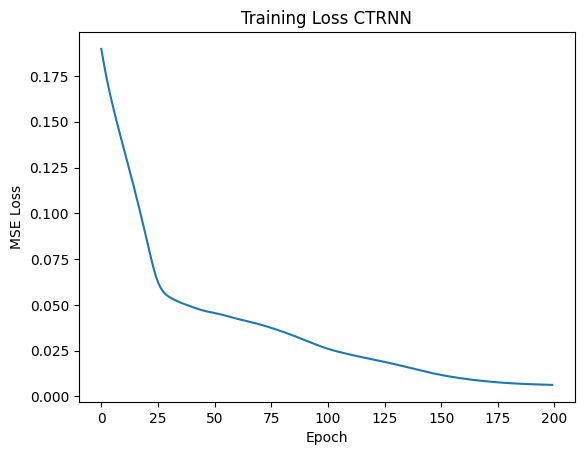

In [39]:
# Affichage de la loss

plt.figure()
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss CTRNN")
plt.savefig(f"images/loss_hiddensize={hidden_size}_tau={tau}_lr={lr}_epochs={epochs}.png")
plt.show()

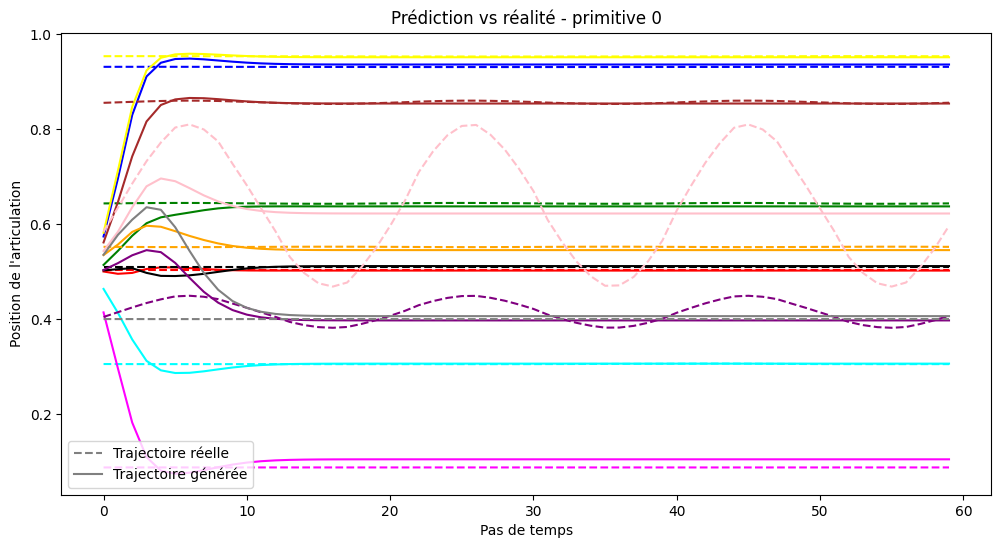

In [40]:
# Graphe prédiction vs réalité

def generate_primitive(model, bias, T):

    sj = torch.tensor([[bias]], dtype=torch.float32).to(device)
    Y = model.forward(sj, T)

    return Y.detach().cpu()

Q0 = torch.tensor(np.load(base_path+"p0.npy"),
                  dtype=torch.float32).unsqueeze(0)

Y0 = generate_primitive(model, 0.1, Q0.shape[1])

colors = [
    "red","green","blue","cyan","magenta","yellow",
    "black","orange","purple","brown","pink","gray"
]
plt.figure(figsize=(12,6))
for joint in range(12):
    plt.plot(Q0[0,:,joint], linestyle="--", color=colors[joint])
    plt.plot(Y0[0,:,joint], color=colors[joint])
plt.plot([],[], "--", color="gray", label="Trajectoire réelle")
plt.plot([],[], "-", color="gray", label="Trajectoire générée")
plt.title("Prédiction vs réalité - primitive 0")
plt.xlabel("Pas de temps")
plt.ylabel("Position de l'articulation")
plt.legend()
plt.savefig(f"images/presvsreal_hiddensize={hidden_size}_tau={tau}_lr={lr}_epochs={epochs}.png")
plt.show()

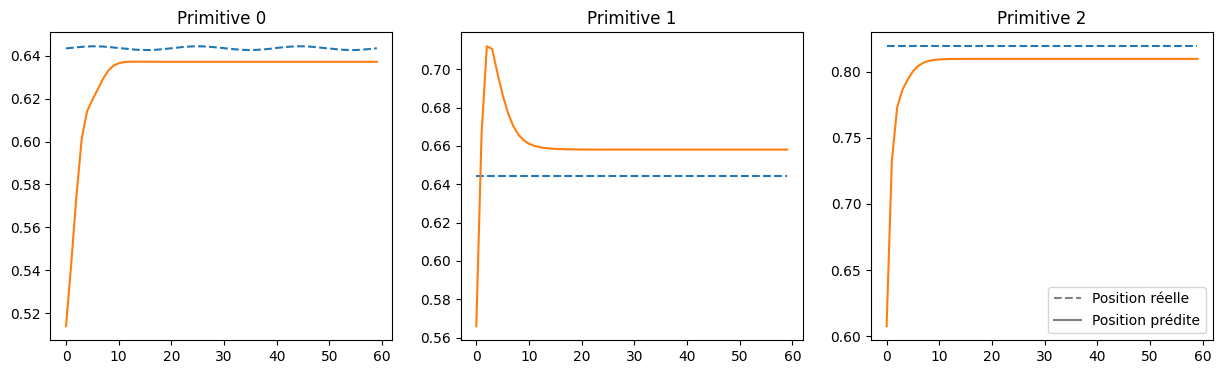

In [43]:
# Tracé pour les 3 primitives

biases = [0.1,0.5,0.9]
files = ["p0.npy","p1.npy","p2.npy"]

plt.figure(figsize=(15,4))

for i in range(3):

    Q = torch.tensor(np.load(base_path+files[i]),
                     dtype=torch.float32).unsqueeze(0)
    Y = generate_primitive(model, biases[i], Q.shape[1])

    plt.subplot(1,3,i+1)
    plt.plot(Q[0,:,1], "--")
    plt.plot(Y[0,:,1])
    plt.xlabel="Pas de temps"
    plt.ylabel="Position articulaire"
    plt.title(f"Primitive {i}")

plt.plot([], [], "--", color="gray", label="Position réelle")
plt.plot([], [], color="gray", label="Position prédite")
plt.legend()
plt.savefig(f"images/troisprim_hiddensize={hidden_size}_tau={tau}_lr={lr}_epochs={epochs}.png")
plt.show()